# Ajustes iniciales

## Conexión a google drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
%cd ./drive/MyDrive/Colab Notebooks/

/content/drive/MyDrive/Colab Notebooks


In [4]:
%pwd

'/content/drive/MyDrive/Colab Notebooks'

## Importar modulos *_utils


In [5]:
import sys
sys.path.append('/content/drive/My Drive/Colab Notebooks/')

from my_utils import eval_utils
from my_utils import nn_utils
from my_utils import dataset_utils
import numpy as np

# Local Utils

## trainFullDatasetClassifiers

In [6]:
import numpy as np
import tensorflow as tf
import pickle
from pandas import DataFrame
from keras.models import model_from_json


def trainFullDatasetClassifiers(task, search_results_path, models_architecture):

  ## get the search_results
  search_results = loadSearchResults(search_results_path)

  ## get the conf_ids for the top results
  conf_ids = getConfigIds(search_results)

  search_results.set_index('conf_ID', inplace=True)

  ## get X_train & Y_train data
  print('Loading train data...')
  X_train, Y_train = getTrainData(task, models_architecture)
  print()

  ## Train the classifiers
  for conf_id in conf_ids:  
    config_data = search_results.loc[conf_id]

    # unpack the configuration data
    best_epoch = config_data['best_epochh']
    median2best = config_data['median2best']
  
    optimizer_id = config_data['optimizer']
    max_epochs  = config_data['max_epochs']
    batch_size = config_data['batch_size']

    ## load and compile the neural network model
    model = loadAndCompileModel(conf_id, optimizer_id, task)

    print('Training classifier for configuration ', conf_id)
    weights_dir = f'./trained_models/{conf_id}'

    acc, model_history = fitModelOnFullDataset(model, 
                                            task, 
                                            X_train, Y_train, 
                                            batch_size, 
                                            max_epochs,
                                            save_weights=True, 
                                            weights_dir=weights_dir,
                                            epochs2watch = [min(best_epoch,max_epochs-1), min(median2best,max_epochs-1)],
                                            verbose=0)

    print(acc, '\n')                                            
    
    # save the full dataset classifier
    with open(f'./history_files/{conf_id}-full-dataset-model.dict', 'wb') as file_handler:
      pickle.dump([model_history], file_handler)

### trainClassifiers utils

In [7]:
def getTrainData(task, architecture):
  if architecture == 'SNN':
    encoding_format = 'SINGLE-VEC'
  else:
    encoding_format = 'EMB-SEQ'

  train_data, train_labels = dataset_utils.loadEncodedTrainData(embedding_type='FT3',
                                                 encoding_format=encoding_format,
                                                 labels_to_return=[task],
                                                 n_folds=7)

  X_train = np.concatenate([train_data[i] for i in range(7)], axis=0)
  Y_train = train_labels[task]

  return X_train, Y_train
  
def loadSearchResults(search_results_path):
  with open(search_results_path, 'rb') as file_handler:
    search_results = pickle.load(file_handler)

  return search_results

def getConfigIds(search_results):
  search_results.sort_values(by='val_acc_A', ascending=False, inplace=True)
  conf_ids = search_results.conf_ID[:5].to_list()
  search_results.sort_values(by='val_acc_B', ascending=False, inplace=True)
  conf_ids.extend(search_results.conf_ID[:5].to_list())
  conf_ids = list(set(conf_ids))

  return conf_ids

def loadAndCompileModel(conf_id, optimizer_id, task):
  # load json and create model
  # we use the models savesd on search experiments
  json_file = open(f'./models_json_files/{conf_id}.json', 'r')
  model_config = json_file.read()
  json_file.close()
  model = model_from_json(model_config)

  # instantiate the corresponding optimizer
  optimizer = optimizers_list[optimizer_id]

  if task=='HTA':
      model.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=["acc"])
  else:
      model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=["acc"])

  return model


### fitModelOnFullDataset()

In [8]:
# **************************   fitNeuralNetworkModel()   **************************

from os import path, makedirs
from  tensorflow.keras.utils import to_categorical

def fitModelOnFullDataset(model, task, X_train, Y_train, batch_size, max_epochs, 
                      save_weights=False, weights_dir='', epochs2watch=[], verbose=0):
  """
  Fits a precompiled keras model to the given data. Saves weights at every apoch
  in epochs2watch.

  inputs:
  model           - precompiled keras model
  task            - str, ['HS','TR', 'AG', 'HTA']
  data            - tuple, (X_train, Y_ytain)
  batch_size      - int 
  max_epochs      - int
  save_weights    - boolean
  weights_dir     - str, filepath to the weights directory
  
  --
  X_train         - numpy_array [shape = N_t, ENCODDING_DIM]
  Y_train         - numpy_array [shape = N_t, 1]
  
  outputs:
  max_acc         - float, max_val_acc registered in model_history (as defined in method A)
  model_history   - dict, model.history.history

  """

  # Callbacks
  if save_weights:
    if not path.exists(weights_dir):
      makedirs(weights_dir)

    # instantiate the custome saver callback
    custom_saver_callback = CustomSaver(weights_dir_path=weights_dir,
                                        epochs2watch=epochs2watch)
    
    callbacks_list = [custom_saver_callback]
      
  else:
    callbacks_list = None

  # For  the 5-classes classification we need to transform 
  # the labels to a one-hot-encoding representation
  if task == 'HTA':
    Y_train = to_categorical(Y_train, num_classes=5)

  model.fit(x=X_train, 
            y=Y_train,
            epochs=max_epochs,
            batch_size=batch_size,
            verbose=verbose,
            callbacks=callbacks_list)
  
  max_acc = max(model.history.history['acc'])

  return max_acc, model.history.history


### customSaver()

In [9]:
# **************************   CustomSaver()   **************************
from keras.callbacks import Callback

class CustomSaver(Callback):
  """
  Saves the model weights at every epoch in epochs2watch.

  """
  
  def __init__(self, weights_dir_path, epochs2watch):
    super(CustomSaver, self).__init__()
    self.weights_dir=weights_dir_path
    self.epochs2watch=epochs2watch

  def on_epoch_end(self, epoch, logs=None):
    if self.epochs2watch:
      if epoch==self.epochs2watch[0]:
        # This ar the weights for the method-A model
        filename = f'global_model_A.hdf5'
        filepath = f'{self.weights_dir}/{filename}'
        self.model.save(filepath,overwrite=True,include_optimizer=False)
      
      if epoch==self.epochs2watch[1]:
        # This are the weights for the method-B model
        filename = f'global_model_B.hdf5'
        filepath = f'{self.weights_dir}/{filename}'
        self.model.save(filepath,overwrite=True,include_optimizer=False)
    else:
      # we ned to keep the weights for every epoch
      filename = f'e{epoch}.hdf5'
      filepath = f'{self.weights_dir}/{filename}'
      self.model.save(filepath,overwrite=True,include_optimizer=False)



### optimizadores


In [10]:
import tensorflow.keras.optimizers as keras_optimizers

optimizers_list = {'adam-1e-3':keras_optimizers.Adam(learning_rate=0.001),
              'adam-7e-4':keras_optimizers.Adam(learning_rate=0.0007),
              'adam-5e-4':keras_optimizers.Adam(learning_rate=0.0005),
              'adam-3e-4':keras_optimizers.Adam(learning_rate=0.0003),
              'adam-1e-4':keras_optimizers.Adam(learning_rate=0.0001),
              'rmsprop-1e-3':keras_optimizers.RMSprop(learning_rate=0.001, momentum=0.0),
              'rmsprop-7e-4':keras_optimizers.RMSprop(learning_rate=0.0007, momentum=0.0),
              'rmsprop-5e-4':keras_optimizers.RMSprop(learning_rate=0.0005, momentum=0.0),
              'rmsprop-3e-4':keras_optimizers.RMSprop(learning_rate=0.0003, momentum=0.0),
              'rmsprop-1e-4':keras_optimizers.RMSprop(learning_rate=0.0001, momentum=0.0),
              'rmsprop-7.5e-5':keras_optimizers.RMSprop(learning_rate=0.000075, momentum=0.0),
              'rmsprop-5e-5':keras_optimizers.RMSprop(learning_rate=0.00005, momentum=0.0),
              'rmsprop-1e-3-mu0.9':keras_optimizers.RMSprop(learning_rate=0.001, momentum=0.9),
              'rmsprop-7e-4-mu0.9':keras_optimizers.RMSprop(learning_rate=0.0007, momentum=0.9),
              'rmsprop-5e-4-mu0.9':keras_optimizers.RMSprop(learning_rate=0.0005, momentum=0.9),
              'rmsprop-3e-4-mu0.9':keras_optimizers.RMSprop(learning_rate=0.0003, momentum=0.9),
              'rmsprop-1e-4-mu0.9':keras_optimizers.RMSprop(learning_rate=0.0001, momentum=0.9),
              'rmsprop-7.5e-5-mu0.9':keras_optimizers.RMSprop(learning_rate=0.000075, momentum=0.9),
              'rmsprop-5e-5-mu0.9':keras_optimizers.RMSprop(learning_rate=0.00005, momentum=0.9)} 

# SNN 

### HS

In [ ]:
trainFullDatasetClassifiers('HS', 
                            search_results_path = './Results/SNN/HS/experiments_4.df',
                            models_architecture = 'SNN')

### TR

In [ ]:
trainFullDatasetClassifiers('TR', 
                            search_results_path = './Results/SNN/TR/experiments_4.df',
                            models_architecture = 'SNN')

Loading train data...
FastText 3 - Spanish Unannotated Corpora
Encoding Format: SINGLE-VEC

Process complete
5000 train instances retrieved

encodings_dim = (300,)

Training classifier for configuration  oWZBcQgF
0.9340000152587891 

Training classifier for configuration  wppcsrma
0.9366000294685364 

Training classifier for configuration  nypkmrjW
0.9082000255584717 

Training classifier for configuration  jawgqxcm
0.9192000031471252 

Training classifier for configuration  jsiehraH
0.8876000046730042 

Training classifier for configuration  BgILeXhk
0.975600004196167 

Training classifier for configuration  JVEIHntQ
0.8960000276565552 



### AG

In [11]:
trainFullDatasetClassifiers('AG', 
                            search_results_path = './Results/SNN/AG/experiments_4.df',
                            models_architecture = 'SNN')

Loading train data...
FastText 3 - Spanish Unannotated Corpora
Encoding Format: SINGLE-VEC

Process complete
5000 train instances retrieved

encodings_dim = (300,)

Training classifier for configuration  ZBIvVzOI
0.9314000010490417 

Training classifier for configuration  FljeuYPX
0.9121999740600586 

Training classifier for configuration  KjzkpEMA
0.9330000281333923 

Training classifier for configuration  kpsolZbm
0.9031999707221985 

Training classifier for configuration  tNmCbkjv
0.9473999738693237 

Training classifier for configuration  WSUJpwQP
0.9002000093460083 

Training classifier for configuration  yCKbOmtc
0.9498000144958496 

Training classifier for configuration  MAIRzcUI
0.9431999921798706 

Training classifier for configuration  ctvTiuoq
0.9603999853134155 



### HTA

In [ ]:
trainFullDatasetClassifiers('HTA', 
                            search_results_path = './Results/SNN/HTA/experiments_4f.df',
                            models_architecture = 'SNN')

Loading train data...
FastText 3 - Spanish Unannotated Corpora
Encoding Format: SINGLE-VEC

Process complete
5000 train instances retrieved

encodings_dim = (300,)

Training classifier for configuration  wScrhgQv
0.8417999744415283 

Training classifier for configuration  KQeFiZqG
0.7387999892234802 

Training classifier for configuration  EJYjTOAq
0.6561999917030334 

Training classifier for configuration  pCqsruJR
0.7585999965667725 

Training classifier for configuration  JzHKJxKW
0.7544000148773193 

Training classifier for configuration  gKzBjYBj
0.7767999768257141 

Training classifier for configuration  pJEUGKCU
0.7947999835014343 

Training classifier for configuration  MYHWkrFV
0.7080000042915344 

Training classifier for configuration  nVhBMnAy
0.7188000082969666 



# CNN 

### HS

In [ ]:
trainFullDatasetClassifiers('HS', 
                            search_results_path = './Results/CNN/HS/experiments_6.df',
                            models_architecture = 'CNN')

Loading train data...
FastText 3 - Spanish Unannotated Corpora
Encoding Format: EMB-SEQ

Process complete
5000 train instances retrieved

encodings_dim = (55, 300)

Training classifier for configuration  ktGXNLsV
0.9908000230789185 

Training classifier for configuration  nFehdAwZ
0.979200005531311 

Training classifier for configuration  lPHcKwYL
0.991599977016449 

Training classifier for configuration  LjUTRRKG
0.9941999912261963 

Training classifier for configuration  DmScKBFk
0.9768000245094299 

Training classifier for configuration  eeitJyKy
0.9911999702453613 

Training classifier for configuration  jLggJPxo
0.9861999750137329 

Training classifier for configuration  MUQKiuDm
0.925000011920929 

Training classifier for configuration  zKWmVuqz
0.9258000254631042 



### TR

In [ ]:
trainFullDatasetClassifiers('TR', 
                            search_results_path = './Results/CNN/TR/experiments_6.df',
                            models_architecture = 'CNN')

Loading train data...
FastText 3 - Spanish Unannotated Corpora
Encoding Format: EMB-SEQ

Process complete
5000 train instances retrieved

encodings_dim = (55, 300)

Training classifier for configuration  XKWyJjCp
0.8238000273704529 

Training classifier for configuration  wrfidhVN
0.9613999724388123 

Training classifier for configuration  oRGmNoZx
0.993399977684021 

Training classifier for configuration  TfFFXlkd
0.9265999794006348 

Training classifier for configuration  pTXwsqCt
0.9944000244140625 

Training classifier for configuration  sWquCUHY
0.9606000185012817 

Training classifier for configuration  oziyYwlg
0.9919999837875366 



### AG

In [ ]:
trainFullDatasetClassifiers('AG', 
                            search_results_path = './Results/CNN/AG/experiments_6.df',
                            models_architecture = 'CNN')

Loading train data...
FastText 3 - Spanish Unannotated Corpora
Encoding Format: EMB-SEQ

Process complete
5000 train instances retrieved

encodings_dim = (55, 300)

Training classifier for configuration  heguIhkD
0.824999988079071 

Training classifier for configuration  AafqTJRJ
0.9945999979972839 

Training classifier for configuration  lYkXiQZd
0.993399977684021 

Training classifier for configuration  lUQlOGae
0.9887999892234802 

Training classifier for configuration  YAsdTTEC
0.9941999912261963 

Training classifier for configuration  QGsgmPVe
0.9837999939918518 

Training classifier for configuration  DztMWiJK


### HTA

In [ ]:
trainFullDatasetClassifiers('HTA', 
                            search_results_path = './Results/SNN/HTA/experiments_4f.df',
                            models_architecture = 'SNN')

Loading train data...
FastText 3 - Spanish Unannotated Corpora
Encoding Format: SINGLE-VEC

Process complete
5000 train instances retrieved

encodings_dim = (300,)

Training classifier for configuration  wScrhgQv
0.8417999744415283 

Training classifier for configuration  KQeFiZqG
0.7387999892234802 

Training classifier for configuration  EJYjTOAq
0.6561999917030334 

Training classifier for configuration  pCqsruJR
0.7585999965667725 

Training classifier for configuration  JzHKJxKW
0.7544000148773193 

Training classifier for configuration  gKzBjYBj
0.7767999768257141 

Training classifier for configuration  pJEUGKCU
0.7947999835014343 

Training classifier for configuration  MYHWkrFV
0.7080000042915344 

Training classifier for configuration  nVhBMnAy
0.7188000082969666 



# BiLSTM

### HS

In [ ]:
trainFullDatasetClassifiers('HS', 
                            search_results_path = './Results/CNN/HS/experiments_6.df',
                            models_architecture = 'CNN')

### TR

In [ ]:
trainFullDatasetClassifiers('TR', 
                            search_results_path = './Results/CNN/TR/experiments_6.df',
                            models_architecture = 'CNN')

### AG

In [ ]:
trainFullDatasetClassifiers('AG', 
                            search_results_path = './Results/CNN/AG/experiments_6.df',
                            models_architecture = 'CNN')

### HTA

In [ ]:
trainFullDatasetClassifiers('HTA', 
                            search_results_path = './Results/SNN/HTA/experiments_4f.df',
                            models_architecture = 'SNN')

# ConvBiLSTM

### HS

In [ ]:
trainFullDatasetClassifiers('HS', 
                            search_results_path = './Results/CNN/HS/experiments_6.df',
                            models_architecture = 'CNN')

Loading train data...
FastText 3 - Spanish Unannotated Corpora
Encoding Format: EMB-SEQ

Process complete
5000 train instances retrieved

encodings_dim = (55, 300)

Training classifier for configuration  ktGXNLsV
0.9908000230789185 

Training classifier for configuration  nFehdAwZ
0.979200005531311 

Training classifier for configuration  lPHcKwYL
0.991599977016449 

Training classifier for configuration  LjUTRRKG
0.9941999912261963 

Training classifier for configuration  DmScKBFk
0.9768000245094299 

Training classifier for configuration  eeitJyKy
0.9911999702453613 

Training classifier for configuration  jLggJPxo
0.9861999750137329 

Training classifier for configuration  MUQKiuDm
0.925000011920929 

Training classifier for configuration  zKWmVuqz
0.9258000254631042 



### TR

In [ ]:
trainFullDatasetClassifiers('TR', 
                            search_results_path = './Results/CNN/TR/experiments_6.df',
                            models_architecture = 'CNN')

Loading train data...
FastText 3 - Spanish Unannotated Corpora
Encoding Format: EMB-SEQ

Process complete
5000 train instances retrieved

encodings_dim = (55, 300)

Training classifier for configuration  XKWyJjCp
0.8238000273704529 

Training classifier for configuration  wrfidhVN
0.9613999724388123 

Training classifier for configuration  oRGmNoZx
0.993399977684021 

Training classifier for configuration  TfFFXlkd
0.9265999794006348 

Training classifier for configuration  pTXwsqCt
0.9944000244140625 

Training classifier for configuration  sWquCUHY
0.9606000185012817 

Training classifier for configuration  oziyYwlg
0.9919999837875366 



### AG

In [ ]:
trainFullDatasetClassifiers('AG', 
                            search_results_path = './Results/CNN/AG/experiments_6.df',
                            models_architecture = 'CNN')

Loading train data...
FastText 3 - Spanish Unannotated Corpora
Encoding Format: EMB-SEQ

Process complete
5000 train instances retrieved

encodings_dim = (55, 300)

Training classifier for configuration  DztMWiJK
0.9965999722480774 

Training classifier for configuration  lUQlOGae
0.995199978351593 

Training classifier for configuration  QGsgmPVe
0.9901999831199646 

Training classifier for configuration  lYkXiQZd
0.9940000176429749 

Training classifier for configuration  AafqTJRJ
0.9929999709129333 

Training classifier for configuration  YAsdTTEC
0.9955999851226807 

Training classifier for configuration  heguIhkD
0.9887999892234802 



### HTA

In [ ]:
trainFullDatasetClassifiers('HTA', 
                            search_results_path = './Results/SNN/HTA/experiments_4f.df',
                            models_architecture = 'SNN')

Loading train data...
FastText 3 - Spanish Unannotated Corpora
Encoding Format: SINGLE-VEC

Process complete
5000 train instances retrieved

encodings_dim = (300,)

Training classifier for configuration  wScrhgQv
0.8417999744415283 

Training classifier for configuration  KQeFiZqG
0.7387999892234802 

Training classifier for configuration  EJYjTOAq
0.6561999917030334 

Training classifier for configuration  pCqsruJR
0.7585999965667725 

Training classifier for configuration  JzHKJxKW
0.7544000148773193 

Training classifier for configuration  gKzBjYBj
0.7767999768257141 

Training classifier for configuration  pJEUGKCU
0.7947999835014343 

Training classifier for configuration  MYHWkrFV
0.7080000042915344 

Training classifier for configuration  nVhBMnAy
0.7188000082969666 



**Train Dataset**

In [ ]:
train_data, train_labels = dataset_utils.loadEncodedTrainData(embedding_type='FT3',
                                                 encoding_format='EMB-SEQ',
                                                 labels_to_return=['HS'],
                                                 n_folds=7)

X_train = np.concatenate([train_data[i] for i in range(7)], axis=0)
Y_train = train_labels['HS']

FastText 3 - Spanish Unannotated Corpora
Encoding Format: EMB-SEQ

Process complete
5000 train instances retrieved

encodings_dim = (55, 300)


**import serch results**

In [ ]:
results_paths = {'CNN':'./Results/CNN/HS_experiments_6f.df',
                 'BiLSTM_HTA':'./Results/LSTM/BiLSTM/HS_experiments_4f.df',
                 'ConvLSTM':'./Results/LSTM/ConvLSTM_HS_experiments_5f.df'}

In [ ]:
import pickle
from pandas import DataFrame

search_results_path = './Results/SNN/HS/experiments_4.df'

with open(search_results_path, 'rb') as file_handler:
  search_results = pickle.load(file_handler)

search_results.shape

(48, 17)

In [ ]:
import pickle
from pandas import DataFrame

search_results_path = './Results/SNN/HS/experiments_4.df'

with open(search_results_path, 'rb') as file_handler:
  search_results = pickle.load(file_handler)

search_results.shape

search_results.sort_values(by='val_acc_A', ascending=False, inplace=True)
conf_ids = search_results.conf_ID[:5].to_list()
search_results.sort_values(by='val_acc_B', ascending=False, inplace=True)
conf_ids.extend(search_results.conf_ID[:5].to_list())
conf_ids = list(set(conf_ids))

In [ ]:
search_results.set_index('conf_ID').loc[conf_ids[0]]['optimizer']

'adam-5e-4'

In [ ]:
search_results.loc[search_results.conf_ID==conf_ids[0]]['optimizer']

28    adam-5e-4
Name: optimizer, dtype: object

In [ ]:
search_results.iloc[0]['optimizer']

'rmsprop-5e-4'

**training**

In [ ]:
import numpy as np
import tensorflow as tf

def trainFullDatasetClassifier(task, search_results):

  train_data, train_labels = dataset_utils.loadEncodedTrainData(embedding_type='FT3',
                                                 encoding_format='EMB-SEQ',
                                                 labels_to_return=[task],
                                                 n_folds=7)

  X_train = np.concatenate([train_data[i] for i in range(7)], axis=0)
  Y_train = train_labels[task]

  for idx in range(0,5):  
    config_data = search_results.iloc[idx]

    conf_id = config_data['conf_ID']
    best_epoch = config_data['best_epochh']
    median2best = config_data['median2best']
    
    # unpack the training parameters
    optimizer_id = config_data['optimizer']
    max_epochs  = config_data['max_epochs']
    batch_size = config_data['batch_size']

    # instantiate the corresponding optimizer
    optimizer = optimizers_list[optimizer_id]

    #arch_params_values = search_results.iloc[idx].loc[arch_params_keys[0]:arch_params_keys[-1]].to_list()
    #arch_params = dict( zip(arch_params_keys, arch_params_values) )

    print('Training classifier for configuration ', conf_id)
    weights_dir = f'./trained_models/{conf_id}'

    #model = convolutionalNetModel('HTA', arch_params, optimizer, verbose=False)

    # load json and create model
    json_file = open(f'./models_json_files/{conf_id}.json', 'r')
    model_config = json_file.read()
    json_file.close()
    model = model_from_json(model_config)

    if task=='HTA':
      model.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=["acc"])
    else:
      model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=["acc"])

    #model.summary()

    acc, model_history = fitModelOnFullDataset(model, 
                                            task, 
                                            X_train, Y_train, 
                                            batch_size, 
                                            max_epochs,
                                            save_weights=True, 
                                            weights_dir=weights_dir,
                                            epochs2watch = [min(best_epoch,max_epochs-1), min(median2best,max_epochs-1)],
                                            verbose=0)
    
    # FTS stands for Full Train Set
    with open(f'./history_files/{conf_id}-full-dataset-model.dict', 'wb') as file_handler:
      pickle.dump([model_history], file_handler)

# OTHER

# EVALUATE TRAINED MODELS ON VALIDATION DATA

##  Train-Dataset

In [ ]:
X_train, Y_train = dataset_utils.loadEncodedTrainData(embedding_type='FT3',
                                                 encoding_format='EMB-SEQ',
                                                 labels_to_return=['HS'],
                                                 n_folds=7)

FastText 3 - Spanish Unannotated Corpora
Encoding Format: EMB-SEQ

Process complete
5000 train instances retrieved

encodings_dim = (55, 300)


In [ ]:
results_paths = {'BiLSTM':'./Results/LSTM/BiLSTM/HTA_experiments_4f.df',
                 'CNN':'./Results/CNN/HTA_experiments_6f.df',
                 'ConvLSTM':'./Results/LSTM/ConvLSTM_HTA_experiments_5f.df'}

## HS

### CNN


In [ ]:
import pickle
from pandas import DataFrame

with open('./Results/CNN/HS_experiments_6f.df', 'rb') as file_handler:
  search_results = pickle.load(file_handler)

search_results.shape

(39, 19)

**CNN-1**

In [ ]:
search_results.sort_values(by='val_acc_A', ascending=False, inplace=True)
config_ids = search_results.conf_ID[:5].to_list()
config_ids

['zKWmVuqz', 'DmScKBFk', 'ktGXNLsV', 'MUQKiuDm', 'jLggJPxo']

In [ ]:
merged_results = DataFrame()

for config_id in config_ids[:]:
  config_metrics_df = evaluateTrainedModelsOnValidationData(X_train, Y_train, 
                                                            'HS', config_id, 'A', 'CNN-1', 7)
  merged_results=merged_results.append(config_metrics_df, ignore_index=True)

*****

In [ ]:
merged_results.shape

(35, 5)

In [ ]:
with open('./Results/final/CNN-1_HS_VALIDATION.df', 'wb') as file_handler:
  pickle.dump(merged_results, file_handler)

In [ ]:
merged_results.head()

,conf_id,model_type,architecture,A_acc,A1_f1
0,zKWmVuqz,F,CNN-1,0.806993,0.797983
1,zKWmVuqz,F,CNN-1,0.826573,0.820358
2,zKWmVuqz,F,CNN-1,0.799720,0.794760
3,zKWmVuqz,F,CNN-1,0.798319,0.790727
4,zKWmVuqz,F,CNN-1,0.831933,0.827376


**CNN-2**

In [ ]:
search_results.sort_values(by='val_acc_B', ascending=False, inplace=True)
config_ids = search_results.conf_ID[:5].to_list()
config_ids

['LjUTRRKG', 'eeitJyKy', 'ktGXNLsV', 'nFehdAwZ', 'lPHcKwYL']

In [ ]:
merged_results = DataFrame()

for config_id in config_ids[:]:
  config_metrics_df = evaluateTrainedModelsOnValidationData(X_train, Y_train, 
                                                            'HS', config_id, 'B', 'CNN-2', 7)
  merged_results=merged_results.append(config_metrics_df, ignore_index=True)

*****

In [ ]:
merged_results.shape

(35, 5)

In [ ]:
with open('./Results/final/CNN-2_HS_VALIDATION.df', 'wb') as file_handler:
  pickle.dump(merged_results, file_handler)

In [ ]:
merged_results.head()

,conf_id,model_type,architecture,A_acc,A1_f1
0,LjUTRRKG,F,CNN-2,0.813986,0.803388
1,LjUTRRKG,F,CNN-2,0.825175,0.820777
2,LjUTRRKG,F,CNN-2,0.812325,0.806293
3,LjUTRRKG,F,CNN-2,0.805322,0.795431
4,LjUTRRKG,F,CNN-2,0.844538,0.840248


### BiLSTM

In [ ]:
import pickle
from pandas import DataFrame

with open('./Results/LSTM/BiLSTM/HS_experiments_4f.df', 'rb') as file_handler:
  search_results = pickle.load(file_handler)

search_results.shape

(32, 17)

**BiLSTM-1**

In [ ]:
search_results.sort_values(by='val_acc_A', ascending=False, inplace=True)
config_ids = search_results.conf_ID[:5].to_list()
config_ids

['NNShMXkr', 'DCTsOBRI', 'DZelNYtT', 'gTKOYXsl', 'BmUVgDql']

In [ ]:
merged_results = DataFrame()

for config_id in config_ids[:]:
  config_metrics_df = evaluateTrainedModelsOnValidationData(X_train, Y_train, 
                                                            'HS', config_id, 'A', 'BiLSTM-1', 7)
  merged_results=merged_results.append(config_metrics_df, ignore_index=True)

*****

In [ ]:
merged_results.shape

(35, 5)

In [ ]:
with open('./Results/final/BiLSTM-1_HS_VALIDATION.df', 'wb') as file_handler:
  pickle.dump(merged_results, file_handler)

In [ ]:
merged_results.head()

,conf_id,model_type,architecture,A_acc,A1_f1
0,NNShMXkr,F,BiLSTM-1,0.804196,0.797178
1,NNShMXkr,F,BiLSTM-1,0.826573,0.823322
2,NNShMXkr,F,BiLSTM-1,0.796919,0.789156
3,NNShMXkr,F,BiLSTM-1,0.813725,0.808940
4,NNShMXkr,F,BiLSTM-1,0.816527,0.812627


**BiLSTM-2**

In [ ]:
search_results.sort_values(by='val_acc_B', ascending=False, inplace=True)
config_ids = search_results.conf_ID[:5].to_list()
config_ids

['DCTsOBRI', 'cwHZKRDu', 'BmUVgDql', 'BIIMyepM', 'DZelNYtT']

In [ ]:
merged_results = DataFrame()

for config_id in config_ids[:]:
  config_metrics_df = evaluateTrainedModelsOnValidationData(X_train, Y_train, 
                                                            'HS', config_id, 'B', 'BiLSTM-2', 7)
  merged_results=merged_results.append(config_metrics_df, ignore_index=True)

*****

In [ ]:
merged_results.shape

(35, 5)

In [ ]:
with open('./Results/final/BiLSTM-2_HS_VALIDATION.df', 'wb') as file_handler:
  pickle.dump(merged_results, file_handler)

In [ ]:
merged_results.head()

,conf_id,model_type,architecture,A_acc,A1_f1
0,DCTsOBRI,F,BiLSTM-2,0.823776,0.818756
1,DCTsOBRI,F,BiLSTM-2,0.834965,0.832485
2,DCTsOBRI,F,BiLSTM-2,0.826331,0.819387
3,DCTsOBRI,F,BiLSTM-2,0.817927,0.813164
4,DCTsOBRI,F,BiLSTM-2,0.822129,0.818784


### ConvLSTM

In [ ]:
import pickle
from pandas import DataFrame

with open('./Results/LSTM/ConvLSTM_HS_experiments_5f.df', 'rb') as file_handler:
  search_results = pickle.load(file_handler)

search_results.shape

(15, 22)

**ConvLSTM-1**

In [ ]:
search_results.sort_values(by='val_acc_A', ascending=False, inplace=True)
config_ids = search_results.conf_ID[:5].to_list()
config_ids

['drfMCabN', 'dgJpafDh', 'ucHXnWZk', 'SgzKWUEe', 'MvOlAtXJ']

In [ ]:
merged_results = DataFrame()

for config_id in config_ids[:]:
  config_metrics_df = evaluateTrainedModelsOnValidationData(X_train, Y_train, 
                                                            'HS', config_id, 'A', 'ConvLSTM-1', 7)
  merged_results=merged_results.append(config_metrics_df, ignore_index=True)

*****

In [ ]:
merged_results.shape

(35, 5)

In [ ]:
with open('./Results/final/ConvLSTM-1_HS_VALIDATION.df', 'wb') as file_handler:
  pickle.dump(merged_results, file_handler)

In [ ]:
merged_results.head()

,conf_id,model_type,architecture,A_acc,A1_f1
0,drfMCabN,F,ConvLSTM-1,0.806993,0.800499
1,drfMCabN,F,ConvLSTM-1,0.836364,0.832095
2,drfMCabN,F,ConvLSTM-1,0.806723,0.804388
3,drfMCabN,F,ConvLSTM-1,0.817927,0.808552
4,drfMCabN,F,ConvLSTM-1,0.802521,0.800871


**Conv-LSTM-2**

In [ ]:
search_results.sort_values(by='val_acc_B', ascending=False, inplace=True)
config_ids = search_results.conf_ID[:5].to_list()
config_ids

['MvOlAtXJ', 'gWDhCaka', 'QOTsRhWU', 'hVisuYls', 'YJycTEil']

In [ ]:
merged_results = DataFrame()

for config_id in config_ids[:]:
  config_metrics_df = evaluateTrainedModelsOnValidationData(X_train, Y_train, 
                                                            'HS', config_id, 'B', 'ConvLSTM-2', 7)
  merged_results=merged_results.append(config_metrics_df, ignore_index=True)

*****

In [ ]:
merged_results.shape

(35, 5)

In [ ]:
with open('./Results/final/ConvLSTM-2_HS_VALIDATION.df', 'wb') as file_handler:
  pickle.dump(merged_results, file_handler)

In [ ]:
merged_results.head()

,conf_id,model_type,architecture,A_acc,A1_f1
0,MvOlAtXJ,F,ConvLSTM-2,0.820979,0.816720
1,MvOlAtXJ,F,ConvLSTM-2,0.837762,0.834720
2,MvOlAtXJ,F,ConvLSTM-2,0.808123,0.801009
3,MvOlAtXJ,F,ConvLSTM-2,0.813725,0.807030
4,MvOlAtXJ,F,ConvLSTM-2,0.816527,0.811983


## HTA

### CNN


In [ ]:
import pickle
from pandas import DataFrame

with open('./Results/CNN/HTA_experiments_6f.df', 'rb') as file_handler:
  search_results = pickle.load(file_handler)

search_results.shape

(96, 19)

**CNN-1**

In [ ]:
search_results.sort_values(by='val_acc_A', ascending=False, inplace=True)
config_ids = search_results.conf_ID[:5].to_list()
config_ids

['EhlKsruy', 'buWKkGpy', 'QXhDykIQ', 'HqQmJDCM', 'SYXMBoXE']

In [ ]:
merged_results = DataFrame()

for config_id in config_ids[:]:
  config_metrics_df = evaluateTrainedModels(X_train, Y_train, 'HTA', config_id, 'A', 'CNN-1', 7)
  merged_results=merged_results.append(config_metrics_df, ignore_index=True)

*****

In [ ]:
merged_results.shape

(35, 11)

In [ ]:
with open('./Results/final/CNN-1_HTA_VALIDATION.df', 'wb') as file_handler:
  pickle.dump(merged_results, file_handler)

In [ ]:
merged_results.head()

**CNN-2**

In [ ]:
search_results.sort_values(by='val_acc_B', ascending=False, inplace=True)
config_ids = search_results.conf_ID[:5].to_list()
config_ids

['xCdcvedN', 'YBJbUNaX', 'WFNrfnfd', 'GWVBtYHV', 'PZKzUveQ']

In [ ]:
merged_results = DataFrame()

for config_id in config_ids[:]:
  config_metrics_df = evaluateTrainedModels(X_train, Y_train, 'HTA', config_id, 'B', 'CNN-2', 7)
  merged_results=merged_results.append(config_metrics_df, ignore_index=True)

*****

In [ ]:
merged_results.shape

(35, 11)

In [ ]:
with open('./Results/final/CNN-2_HTA_VALIDATION.df', 'wb') as file_handler:
  pickle.dump(merged_results, file_handler)

In [ ]:
merged_results.head()

,conf_id,model_type,architecture,A_acc,B1_acc,B2_acc,A1_f1,B1_f1,B2_f1,F1_multi,EMR
0,xCdcvedN,F,CNN-2,0.804196,0.890909,0.816783,0.791103,0.854681,0.792634,0.812806,0.765035
1,xCdcvedN,F,CNN-2,0.827972,0.900699,0.834965,0.819374,0.861610,0.812601,0.831195,0.784615
2,xCdcvedN,F,CNN-2,0.816527,0.901961,0.822129,0.807205,0.867018,0.803282,0.825835,0.780112
3,xCdcvedN,F,CNN-2,0.806723,0.914566,0.837535,0.790971,0.883889,0.813996,0.829619,0.771709
4,xCdcvedN,F,CNN-2,0.816527,0.897759,0.810924,0.808860,0.865663,0.793206,0.822576,0.770308


### BiLSTM

In [ ]:
import pickle
from pandas import DataFrame

with open(results_paths['BiLSTM'], 'rb') as file_handler:
  search_results = pickle.load(file_handler)

search_results.shape

(32, 17)

**BiLSTM-1**

In [ ]:
search_results.sort_values(by='val_acc_A', ascending=False, inplace=True)
config_ids = search_results.conf_ID[:5].to_list()
config_ids

['AaAfwcAd', 'IkVKqPgr', 'WMgyUskY', 'NqCxMCfs', 'UXkEVLOO']

In [ ]:
merged_results = DataFrame()

for config_id in config_ids[:]:
  config_metrics_df = evaluateTrainedModels(X_train, Y_train, 'HTA', config_id, 'A', 'BiLSTM-1', 7)
  merged_results=merged_results.append(config_metrics_df, ignore_index=True)

*****

In [ ]:
merged_results.shape

(35, 11)

In [ ]:
with open('./Results/final/BiLSTM-1_HTA_VALIDATION.df', 'wb') as file_handler:
  pickle.dump(merged_results, file_handler)

In [ ]:
merged_results.head()

**BiLSTM-2**

In [ ]:
search_results.sort_values(by='val_acc_B', ascending=False, inplace=True)
config_ids = search_results.conf_ID[:5].to_list()
config_ids

['AaAfwcAd', 'NqCxMCfs', 'IkVKqPgr', 'WMgyUskY', 'CfKziEoZ']

In [ ]:
merged_results = DataFrame()

for config_id in config_ids[:]:
  config_metrics_df = evaluateTrainedModels(X_train, Y_train, 'HTA', config_id, 'B', 'BiLSTM-2', 7)
  merged_results=merged_results.append(config_metrics_df, ignore_index=True)

*****

In [ ]:
merged_results.shape

(35, 11)

In [ ]:
with open('./Results/final/BiLSTM-2_HTA_VALIDATION.df', 'wb') as file_handler:
  pickle.dump(merged_results, file_handler)

In [ ]:
merged_results.head()

,conf_id,model_type,architecture,A_acc,B1_acc,B2_acc,A1_f1,B1_f1,B2_f1,F1_multi,EMR
0,AaAfwcAd,F,BiLSTM-2,0.816783,0.895105,0.822378,0.807870,0.861042,0.800660,0.823191,0.766434
1,AaAfwcAd,F,BiLSTM-2,0.822378,0.911888,0.839161,0.812766,0.884536,0.820955,0.839419,0.783217
2,AaAfwcAd,F,BiLSTM-2,0.815126,0.894958,0.824930,0.805607,0.860977,0.803661,0.823415,0.774510
3,AaAfwcAd,F,BiLSTM-2,0.812325,0.893557,0.827731,0.798975,0.856178,0.802996,0.819383,0.768908
4,AaAfwcAd,F,BiLSTM-2,0.810924,0.892157,0.808123,0.801059,0.855121,0.788197,0.814792,0.766106


### ConvLSTM

In [ ]:
import pickle
from pandas import DataFrame

with open('./Results/LSTM/ConvLSTM_HTA_experiments_5f.df', 'rb') as file_handler:
  search_results = pickle.load(file_handler)

search_results.shape

(26, 22)

**ConvLSTM-1**

In [ ]:
search_results.sort_values(by='val_acc_A', ascending=False, inplace=True)
config_ids = search_results.conf_ID[:5].to_list()
config_ids

['OMbpCcoK', 'plRnsaUy', 'VSHFapYo', 'SgTMMCRk', 'elVbjZow']

In [ ]:
merged_results = DataFrame()

for config_id in config_ids[:]:
  config_metrics_df = evaluateTrainedModels(X_train, Y_train, 'HTA', config_id, 'A', 'ConvLSTM-1', 7)
  merged_results=merged_results.append(config_metrics_df, ignore_index=True)

***********************************

In [ ]:
merged_results.shape

(35, 11)

In [ ]:
with open('./Results/final/ConvLSTM-1_HTA_VALIDATION.df', 'wb') as file_handler:
  pickle.dump(merged_results, file_handler)

In [ ]:
merged_results.head()

,conf_id,model_type,architecture,A_acc,B1_acc,B2_acc,A1_f1,B1_f1,B2_f1,F1_multi,EMR
0,OMbpCcoK,F,ConvLSTM-1,0.809790,0.885315,0.815385,0.802973,0.847229,0.796272,0.815491,0.753846
1,OMbpCcoK,F,ConvLSTM-1,0.820979,0.899301,0.813986,0.814956,0.870100,0.795305,0.826787,0.765035
2,OMbpCcoK,F,ConvLSTM-1,0.822129,0.907563,0.834734,0.810200,0.876053,0.814464,0.833572,0.781513
3,OMbpCcoK,F,ConvLSTM-1,0.815126,0.915966,0.829132,0.802279,0.888164,0.807367,0.832603,0.777311
4,OMbpCcoK,F,ConvLSTM-1,0.820728,0.901961,0.834734,0.811498,0.872324,0.818085,0.833969,0.781513


**Conv-LSTM-2**

In [ ]:
search_results.sort_values(by='val_acc_B', ascending=False, inplace=True)
config_ids = search_results.conf_ID[:5].to_list()
config_ids

['plRnsaUy', 'VSHFapYo', 'OMbpCcoK', 'elVbjZow', 'ExiNtXSD']

In [ ]:
merged_results = DataFrame()

for config_id in config_ids[:]:
  config_metrics_df = evaluateTrainedModels(X_train, Y_train, 'HTA', config_id, 'B', 'ConvLSTM-2', 7)
  merged_results=merged_results.append(config_metrics_df, ignore_index=True)

*****

In [ ]:
merged_results.shape

(35, 11)

In [ ]:
with open('./Results/final/ConvLSTM-2_HTA_VALIDATION.df', 'wb') as file_handler:
  pickle.dump(merged_results, file_handler)

In [ ]:
merged_results.head()

,conf_id,model_type,architecture,A_acc,B1_acc,B2_acc,A1_f1,B1_f1,B2_f1,F1_multi,EMR
0,plRnsaUy,F,ConvLSTM-2,0.834965,0.904895,0.826573,0.826379,0.872837,0.808978,0.836065,0.784615
1,plRnsaUy,F,ConvLSTM-2,0.848951,0.903497,0.847552,0.845221,0.878170,0.831610,0.851667,0.793007
2,plRnsaUy,F,ConvLSTM-2,0.822129,0.900560,0.823529,0.814256,0.865898,0.804644,0.828266,0.782913
3,plRnsaUy,F,ConvLSTM-2,0.824930,0.917367,0.819328,0.815795,0.885890,0.796530,0.832738,0.768908
4,plRnsaUy,F,ConvLSTM-2,0.826331,0.910364,0.837535,0.816152,0.879351,0.813996,0.836500,0.785714


# Confussion Matrix

###  Test-Dataset

In [ ]:
X_test, Y_test = dataset_utils.loadEncodedTestData(embedding_type='FT3',
                                                 encoding_format='EMB-SEQ',
                                                 labels_to_return = ['HTA'])

FastText 3 - Spanish Unannotated Corpora
Encoding Format: EMB-SEQ

Process complete
1600 test instances retrieved

encodings_dim = (55, 300)


In [ ]:
X_test, Y_test = dataset_utils.loadEncodedTestData(embedding_type='FT3',
                                                 encoding_format='EMB-SEQ',
                                                 labels_to_return = ['HS','TR','AG','HTA'])

FastText 3 - Spanish Unannotated Corpora
Encoding Format: EMB-SEQ

Process complete
1600 test instances retrieved

encodings_dim = (55, 300)


In [ ]:
Y_test.HTA.value_counts()

0    940
4    371
1    134
2    103
3     52
Name: HTA, dtype: int64

In [ ]:
HTA_pred = getModelPredictions(X_test, 'OMbpCcoK', 'HTA', 'B', 'E1')

from sklearn.metrics import confusion_matrix
HTA_true = Y_test.HTA.to_numpy()
HTA_pred = predictions

confusion_matrix(HTA_true, HTA_pred)

array([[818,   1,  64,   0,  57],
       [ 78,   0,  49,   0,   7],
       [ 41,   0,  54,   0,   8],
       [ 29,   0,   5,   0,  18],
       [ 93,   0,   7,   0, 271]])

In [ ]:
"""
0 -> (0,0,0)  [HT = 0, TR = 0, AG = 0]
1 -> (1,0,0)  [HT = 1, TR = 0, AG = 0]
2 -> (1,0,1)  [HT = 1, TR = 0, AG = 1]
3 -> (1,1,0)  [HT = 1, TR = 1, AG = 0]
4 -> (1,1,1)  [HT = 1, TR = 1, AG = 1]
"""

In [ ]:
HS_pred, TR_pred, AG_pred = getLabelsPerTask(predictions)

HS_true, TR_true, AG_true = [Y_test['HS'], Y_test['TR'], Y_test['AG']]
HS_true = HS_true.to_numpy()
TR_true = TR_true.to_numpy()
AG_true = AG_true.to_numpy()

In [ ]:
confusion_matrix(HS_true, HS_pred)

array([[818, 122],
       [241, 419]])

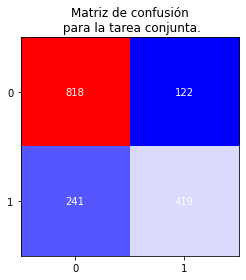

In [ ]:
plotConfMatrix(confusion_matrix(HS_true, HS_pred), ['0','1'])

In [ ]:
confusion_matrix(HS_true, HS_pred)

array([[818, 122],
       [241, 419]])

In [ ]:
confusion_matrix(TR_true, TR_pred)

array([[1105,   72],
       [ 134,  289]])

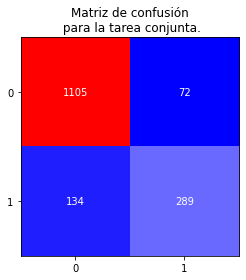

In [ ]:
plotConfMatrix(confusion_matrix(TR_true, TR_pred), ['0','1'])

In [ ]:
confusion_matrix(AG_true, AG_pred)

array([[926, 200],
       [134, 340]])

In [ ]:
predictions = getModelPredictions(X_test, 'OMbpCcoK', 'HTA', 'B', 'E2')

from sklearn.metrics import confusion_matrix
y_true = Y_test.HTA.to_numpy()
y_pred = predictions

confusion_matrix(y_true, y_pred)

array([[818,   1,  64,   0,  57],
       [ 78,   0,  49,   0,   7],
       [ 41,   0,  54,   0,   8],
       [ 29,   0,   5,   0,  18],
       [ 93,   0,   7,   0, 271]])

In [ ]:
predictions = getModelPredictions(X_test, 'YBJbUNaX', 'HTA', 'A', 'E1')

from sklearn.metrics import confusion_matrix
y_true = Y_test.HTA.to_numpy()
y_pred = predictions

cm = confusion_matrix(y_true, y_pred)

In [ ]:
import matplotlib
import matplotlib.pyplot as plt
#labels = ["0,0,0", "1,0,0", "1,0,1", "1,1,0", "1,1,1"]

def plotConfMatrix(values, labels):

  fig, ax = plt.subplots()
  im = ax.imshow(values, cmap='bwr')

  # We want to show all ticks...
  ax.set_xticks(np.arange(len(labels)))
  ax.set_yticks(np.arange(len(labels)))
  # ... and label them with the respective list entries
  ax.set_xticklabels(labels)
  ax.set_yticklabels(labels)

  # Rotate the tick labels and set their alignment.
  plt.setp(ax.get_xticklabels(), rotation=0, ha="center",
          rotation_mode="anchor")

  # Loop over data dimensions and create text annotations.
  for i in range(len(labels)):
      for j in range(len(labels)):
          text = ax.text(j, i, values[i, j],
                        ha="center", va="center", color="w")

  ax.set_title("Matriz de confusión\n para la tarea conjunta.")
  fig.tight_layout()
  plt.show()

In [ ]:
"""
0 -> (0,0,0)  [HT = 0, TR = 0, AG = 0]
1 -> (1,0,0)  [HT = 1, TR = 0, AG = 0]
2 -> (1,0,1)  [HT = 1, TR = 0, AG = 1]
3 -> (1,1,0)  [HT = 1, TR = 1, AG = 0]
4 -> (1,1,1)  [HT = 1, TR = 1, AG = 1]
"""

## evaluation

In [ ]:
merged_results = DataFrame()

config_ids = ['xCdcvedN', 'YBJbUNaX', 'WFNrfnfd', 'GWVBtYHV', 'PZKzUveQ']

for config_id in config_ids[:]:
  config_metrics_df = evaluateTrainedModels(X_train, Y_train, 'HTA', config_id, 'B', 'CNN2', 7)
  merged_results=merged_results.append(config_metrics_df, ignore_index=True)

*****

In [ ]:
merged_results.shape

(35, 11)

In [ ]:
with open('./Results/final/CNN2_HTA_VALIDATION.df', 'wb') as file_handler:
  pickle.dump(merged_results, file_handler)

In [ ]:
merged_results

,conf_id,model_type,architecture,A_acc,B1_acc,B2_acc,A1_f1,B1_f1,B2_f1,F1_multi,EMR
0,xCdcvedN,F,CNN2,0.804196,0.890909,0.816783,0.791103,0.854681,0.792634,0.812806,0.765035
1,xCdcvedN,F,CNN2,0.827972,0.900699,0.834965,0.819374,0.861610,0.812601,0.831195,0.784615
2,xCdcvedN,F,CNN2,0.816527,0.901961,0.822129,0.807205,0.867018,0.803282,0.825835,0.780112
3,xCdcvedN,F,CNN2,0.806723,0.914566,0.837535,0.790971,0.883889,0.813996,0.829619,0.771709
4,xCdcvedN,F,CNN2,0.816527,0.897759,0.810924,0.808860,0.865663,0.793206,0.822576,0.770308
5,xCdcvedN,F,CNN2,0.817927,0.903361,0.830532,0.809520,0.873478,0.812933,0.831977,0.782913
6,xCdcvedN,F,CNN2,0.824930,0.910364,0.829132,0.814798,0.877456,0.809348,0.833868,0.782913
7,YBJbUNaX,F,CNN2,0.815385,0.899301,0.827972,0.806525,0.864848,0.809982,0.827118,0.772028
8,YBJbUNaX,F,CNN2,0.819580,0.907692,0.850350,0.805243,0.876111,0.825461,0.835605,0.784615
9,YBJbUNaX,F,CNN2,0.813725,0.899160,0.817927,0.804760,0.866292,0.797253,0.822769,0.767507


In [ ]:
evaluateTrainedModels(X_train, Y_train, 'HTA', 'buWKkGpy', 'A', 'CNN1', 7)

buWKkGpy 


Evaluating data-fold 0
EMR =  0.765034965034965
F1_multi =  0.8118190853762185


Evaluating data-fold 1
EMR =  0.765034965034965
F1_multi =  0.8269660028725091


Evaluating data-fold 2
EMR =  0.7591036414565826
F1_multi =  0.8024194971785185


Evaluating data-fold 3
EMR =  0.7675070028011205
F1_multi =  0.8182651368812829


Evaluating data-fold 4
EMR =  0.7759103641456583
F1_multi =  0.8216148933234292


Evaluating data-fold 5
EMR =  0.773109243697479
F1_multi =  0.8249080067621691


Evaluating data-fold 6
EMR =  0.7787114845938375
F1_multi =  0.8271790017287962



,conf_id,model_type,architecture,A_acc,B1_acc,B2_acc,A1_f1,B1_f1,B2_f1,F1_multi,EMR
0,buWKkGpy,F,CNN1,0.805594,0.885315,0.815385,0.794519,0.846656,0.794282,0.811819,0.765035
1,buWKkGpy,F,CNN1,0.822378,0.900699,0.812587,0.814868,0.869874,0.796156,0.826966,0.765035
2,buWKkGpy,F,CNN1,0.796919,0.893557,0.806723,0.781266,0.848296,0.777697,0.802419,0.759104
3,buWKkGpy,F,CNN1,0.805322,0.904762,0.827731,0.788202,0.865432,0.801161,0.818265,0.767507
4,buWKkGpy,F,CNN1,0.823529,0.903361,0.805322,0.813701,0.868144,0.783000,0.821615,0.775910
5,buWKkGpy,F,CNN1,0.817927,0.904762,0.813725,0.808045,0.872297,0.794381,0.824908,0.773109
6,buWKkGpy,F,CNN1,0.823529,0.904762,0.826331,0.810383,0.868216,0.802938,0.827179,0.778711


# NN TRAINING A GLOBAL CLASSIFIER

## Dataset

In [ ]:
X_train_data, Y_train = dataset_utils.loadEncodedTrainData(embedding_type='FT3',
                                                 encoding_format='SINGLE-VEC',
                                                 labels_to_return=['HTA'],
                                                 n_folds=7)

FastText 3 - Spanish Unannotated Corpora
Encoding Format: SINGLE-VEC

Process complete
5000 train instances retrieved

encodings_dim = (300,)


In [ ]:
import numpy as np
import tensorflow as tf

In [ ]:
X_train = np.concatenate([X_train_data[i] for i in range(7)], axis=0)

In [ ]:
Y_train_labels = Y_train['HTA']
Y_train_labels = tf.keras.utils.to_categorical(Y_train_labels, num_classes=5)

## GETTING THE KERAS MODEL

In [ ]:
XVMKseLS	300	75	relu	0.5	0.5	rmsprop-1e-3	512	100	46

In [ ]:
arch_params= {
    'L1_size': 300,                    
    'L2_size': 75,                
    'activation':'relu',                                    
    'p_dropout_1': 0.5,
    'p_dropout_2': 0.5                                
}

import tensorflow.keras.optimizers as keras_optimizers
optimizer = keras_optimizers.Adam(learning_rate=0.001)

my_keras_model = fcNeuralNetworkModel('HTA', arch_params, optimizer, verbose=True)

Model: "model_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
INPUT (InputLayer)           [(None, 300)]             0         
_________________________________________________________________
DL_1 (Dense)                 (None, 300)               90300     
_________________________________________________________________
DROPOUT_1 (Dropout)          (None, 300)               0         
_________________________________________________________________
DL_2 (Dense)                 (None, 75)                22575     
_________________________________________________________________
DROPOUT_2 (Dropout)          (None, 75)                0         
_________________________________________________________________
PREDICTOR (Dense)            (None, 5)                 380       
_________________________________________________________________
reshape_21 (Reshape)         (None, 5)                 0  

## FITTING THE KERAS MODEL

In [ ]:
my_keras_model = fcNeuralNetworkModel('HTA', arch_params, optimizer, verbose=True)

my_keras_model.fit(x=X_train_merged, 
            y=Y_train_labels,
            epochs=2,
            batch_size=512,
            verbose=2)

Epoch 1/2
10/10 - 0s - loss: 0.5808 - acc: 0.7824
Epoch 2/2
10/10 - 0s - loss: 0.6063 - acc: 0.7632


In [ ]:
import pickle

In [ ]:
X_test, Y_test = loadEncodedTestData(embedding_type='FT3',
                                    encoding_format='SINGLE-VEC',
                                    labels_to_return=['HTA'])

FastText 3 - Spanish Unannotated Corpora
Encoding Format: SINGLE-VEC

Process complete
1600 test instances retrieved

encodings_dim = (300,)


In [ ]:
X_test.shape

(1600, 300)

In [ ]:
target = tf.keras.utils.to_categorical(Y_test['HTA'], num_classes=5)
predicted  = np.where(my_keras_model.predict(X_test) > 0.5, 1, 0)

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

accuracy_s = accuracy_score(target, predicted)
A_f1 = f1_score(target, predicted, average="macro")

In [ ]:
accuracy_s, A_f1

(0.644375, 0.31944394467199566)

# *****

### Retrieve DataFrame with the test instances

In [ ]:
import pickle
with open('./dataset_files/preprocessed_test_dataset.data', 'rb') as file_handler:
  test_dataset = pickle.load(file_handler)

In [ ]:
test_dataset.head()

,id,text,preprocessed_text_1,preprocessed_text_2,HS,TR,AG,HTA
0,30344,#CadaMañana cállate la puta que me pario Kohan...,"[htg, cállate, la, puta, que, me, pario, kohan...","[cállate, la, puta, que, me, pario, kohan, vos...",0,0,0,0
1,30466,Estas navidades mi polla mereces,"[estas, navidades, mi, polla, mereces]","[estas, navidades, mi, polla, mereces]",0,0,0,0
2,31084,Si no aprobas te pego una cojida que no te la ...,"[si, no, aprobas, te, pego, una, cojida, que, ...","[si, no, aprobas, te, pego, una, cojida, que, ...",1,1,1,4
3,34552,"@AlecitoGamer @falklands_utd A, no entendiste ...","[nombre, nombre, a, no, entendiste, nada, ud, ...","[nombre, nombre, a, no, entendiste, nada, ud, ...",0,0,0,0
4,32538,"@deborahhq1973 Es normal, en Cataluña los Inde...","[nombre, es, normal, en, cataluña, los, indepe...","[nombre, es, normal, en, cataluña, los, indepe...",1,0,1,2


In [ ]:
df_test.to_pickle('./dataset_files/preprocessed_test_dataset.data', None)

In [ ]:
import numpy as np

In [ ]:
X_train_merged = np.concatenate([X_train[i] for i in range(7)], axis=0)

In [ ]:
import tensorflow as tf

In [ ]:
Y_train_labels = Y_train['HTA']
Y_train_labels = tf.keras.utils.to_categorical(Y_train_labels, num_classes=5)

# SANDBOX

In [ ]:
import numpy as np
a = np.array([[1,0,0,1,1],
              [0,1,0,0,1],
              [1,0,0,1,1]])

map = np.zeros_like(a) - 1
b

array([[-1, -1, -1, -1, -1],
       [-1, -1, -1, -1, -1],
       [-1, -1, -1, -1, -1]])

In [ ]:
w, h = a.shape
islands_count = -1
for i in range(w):
  for j in range(h):
    if a[i,j]==1:
      m = get_island_mark(i,j,map)
      update_map(i,j,m,map)

      if land_to_the_right(i,j,b):
        b[i,j] = b[i-1,j]
      elif land_above(i,j,b):
        b[i,j] = b[i,j-1]
      else:
        islands_count += 1
        b[i,j]=islands_count

In [ ]:
def get_island_mark(i,j,map):
  w, h = a.shape
  # look right
  if (i >= 1) & (b[i-1,j]>-1):
    return b[i-1,j]
  # look left
  if (i <= w-2) & (b[i+1,j]>-1):
    return b[i-1,j]

array([[ 0, -1, -1,  1,  1],
       [-1,  2, -1, -1,  1],
       [ 3, -1, -1,  4,  1]])

In [ ]:
def land_to_the_right(i,j,b):
  if (i >= 1) & (b[i-1,j]>-1):
    return True
  else: 
    return False

def land_above(i,j,b):
  if (j >= 1) & (b[i,j-1]>-1):
    return True
  else: 
    return False